##### TODO
- [ ] Put all figures together and write down the questions explicitly (first paragraph with technical details, second with interpretation, finally write the answer of the initial question)

__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count

import matplotlib.patches as mpatches  # create custom plot legends
import matplotlib.pyplot as plt  # mother of plots focr Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display  # print nicely
from matplotlib.lines import Line2D  # matplotlib custom lines
from scipy import stats  # statistical tests
from statsmodels.multivariate.manova import MANOVA  # test results with MANOVA
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [2]:
warnings.filterwarnings("ignore")
# set default float display format to 2 decimals
pd.options.display.float_format = "{:.3f}".format

STYLE = "whitegrid"
sns.set(rc={"figure.figsize": (8, 6)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style

PATH_PROC = "./data/processed"

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

org_grps = [
    "Buildings",
    "Dynamic Cars",
    "Dynamic Pedestrians",
    "Inside Car",
    "Nature",
    "Roads",
    "Static Cars",
    "Static Pedestrians",
    "Street Objects",
    "Traffic Lights",
    "Traffic Signs",
]

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 16


In [3]:
def statistic(a, b):
    """
    Given two lists representing the distributions of two conditions,
    return the difference between their means.

    Parameters:
        a (list): Values of distribution A.
        b (list): Values of distribution B.
    Returns:
        (float): Difference between medians A and B.
    """
    return np.mean(a) - np.mean(b)


def permutationTest(a, b, n_perms):
    """
    Compute gaze vs rest stats and store gaze length and gaze counts (events)
    of a participant given its UID.

    Parameters:
        uid (str): Participant unique identifier.
    """

    # actual distribution test (difference between medians in this case)
    actual = statistic(a, b)

    # collect original lengths for randomization
    l_a = len(a)
    l_b = len(b)
    # concatenate values
    cmb = a + b

    stats = []
    under = 0
    for count in range(n_perms):
        # shuffle values
        rnd = np.random.permutation(cmb)
        a_rnd = rnd[:l_a]
        b_rnd = rnd[l_b:]
        # compute statistic
        stat = statistic(a_rnd, b_rnd)
        stats.append(stat)
        if stat <= actual:
            under += 1
    under_per = under * 100.0 / (count + 1)
    return actual, stats, under_per

In [4]:
parts = pd.read_csv("./participants_clean.csv", keep_default_na=False)
parts = parts.set_index("id")  # set uid column as index (remove default)
parts

,date,expo,side,condition,nulls_%,sky_%,insidecar_%,questionnaire
id,,,,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,1.610,13.740,2.359,No
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,0.037,0.674,25.421,No
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,0.037,33.134,0.786,No
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,0.824,18.607,2.845,No
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,0.225,26.994,0.262,No
...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,0.300,32.160,0.000,No
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,0.674,15.462,5.054,No
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,1.797,3.370,11.718,No


In [5]:
hit_levs = pd.read_csv(f"./group_lengths.csv", index_col=0)
hit_levs

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs
4f583872ffed48249874b00f3d389cfc,18.414,0.924,1.122,1.881,3.597,18.282,0.000,0.000,1.155,13.332,0.000
33d68ad55ef544fab9fd08108e3913ca,0.000,0.594,0.000,28.677,0.297,30.360,0.000,0.000,0.363,4.620,0.000
8598a83e2af441b8bcd0ae5d84beb875,38.313,0.000,0.000,0.627,0.924,0.000,0.000,0.000,0.363,9.207,0.000
37d7e67934974217830bb429bba7fd76,17.259,2.508,1.122,4.719,5.049,1.122,0.330,0.000,2.013,18.777,0.000
42bac596059749b5b8e8e83ae61de9b4,34.584,0.000,0.000,0.528,6.402,0.000,0.000,0.000,2.310,10.362,0.000
...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34.056,0.000,0.000,6.435,2.739,0.000,0.000,0.000,1.023,8.382,0.000
611d35a7c3e940cc82495e53c2a8532d,19.041,0.000,0.000,24.288,4.686,2.838,0.000,0.000,1.056,9.174,0.363
3b6fda285d9e412eb081986b2f22a2e3,7.821,0.000,0.462,18.381,0.660,16.599,0.000,1.122,5.874,5.577,0.000
18ffb0abdc8642098c479380bfa533d1,14.718,0.264,0.000,5.478,4.950,6.402,0.000,0.000,1.485,11.418,0.627


In [6]:
hit_levs = hit_levs.join(
    parts[["expo", "side", "condition", "questionnaire"]], how="outer"
)
hit_levs

,Buildings,Dynamic Cars,Dynamic Pedestrians,Inside Car,Nature,Roads,Static Cars,Static Pedestrians,Street Objects,Traffic Lights,Traffic Signs,expo,side,condition,questionnaire
4f583872ffed48249874b00f3d389cfc,18.414,0.924,1.122,1.881,3.597,18.282,0.000,0.000,1.155,13.332,0.000,MSW,right,TaxiDriver,No
33d68ad55ef544fab9fd08108e3913ca,0.000,0.594,0.000,28.677,0.297,30.360,0.000,0.000,0.363,4.620,0.000,MSW,right,AVAS,No
8598a83e2af441b8bcd0ae5d84beb875,38.313,0.000,0.000,0.627,0.924,0.000,0.000,0.000,0.363,9.207,0.000,MSW,right,RadioTalk,No
37d7e67934974217830bb429bba7fd76,17.259,2.508,1.122,4.719,5.049,1.122,0.330,0.000,2.013,18.777,0.000,MSW,left,AVAS,No
42bac596059749b5b8e8e83ae61de9b4,34.584,0.000,0.000,0.528,6.402,0.000,0.000,0.000,2.310,10.362,0.000,MSW,right,TaxiDriver,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34.056,0.000,0.000,6.435,2.739,0.000,0.000,0.000,1.023,8.382,0.000,BMBF,right,AVAS,No
611d35a7c3e940cc82495e53c2a8532d,19.041,0.000,0.000,24.288,4.686,2.838,0.000,0.000,1.056,9.174,0.363,BMBF,right,TaxiDriver,No
3b6fda285d9e412eb081986b2f22a2e3,7.821,0.000,0.462,18.381,0.660,16.599,0.000,1.122,5.874,5.577,0.000,BMBF,left,AVAS,No
18ffb0abdc8642098c479380bfa533d1,14.718,0.264,0.000,5.478,4.950,6.402,0.000,0.000,1.485,11.418,0.627,BMBF,left,RadioTalk,Yes


Final Groups

In [7]:
final_groups = ["Buildings", "Inside Car", "Nature", "condition"]
# length
gaze_levs = hit_levs[final_groups]
gaze_levs["Cars and Pedestrians"] = (
    hit_levs["Dynamic Cars"] + hit_levs["Dynamic Pedestrians"]
)
gaze_levs["Roads"] = hit_levs["Static Cars"] + hit_levs["Roads"]
gaze_levs["Street Objects"] = (
    hit_levs["Street Objects"] + hit_levs["Static Pedestrians"]
)
gaze_levs["Traffic Signs"] = (
    hit_levs["Traffic Signs"] + hit_levs["Traffic Lights"]
)

# TR vs non-TR
gaze_ltr = pd.DataFrame(columns=["TR", "non-TR"])
gaze_ltr["TR"] = (
    gaze_levs["Cars and Pedestrians"]
    + gaze_levs["Roads"]
    + gaze_levs["Traffic Signs"]
    + gaze_levs["Inside Car"]
)
gaze_ltr["non-TR"] = (
    gaze_levs["Buildings"] + gaze_levs["Nature"] + gaze_levs["Street Objects"]
)
gaze_ltr["condition"] = gaze_levs["condition"]

In [8]:
gaze_levs

,Buildings,Inside Car,Nature,condition,Cars and Pedestrians,Roads,Street Objects,Traffic Signs
4f583872ffed48249874b00f3d389cfc,18.414,1.881,3.597,TaxiDriver,2.046,18.282,1.155,13.332
33d68ad55ef544fab9fd08108e3913ca,0.000,28.677,0.297,AVAS,0.594,30.360,0.363,4.620
8598a83e2af441b8bcd0ae5d84beb875,38.313,0.627,0.924,RadioTalk,0.000,0.000,0.363,9.207
37d7e67934974217830bb429bba7fd76,17.259,4.719,5.049,AVAS,3.630,1.452,2.013,18.777
42bac596059749b5b8e8e83ae61de9b4,34.584,0.528,6.402,TaxiDriver,0.000,0.000,2.310,10.362
...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34.056,6.435,2.739,AVAS,0.000,0.000,1.023,8.382
611d35a7c3e940cc82495e53c2a8532d,19.041,24.288,4.686,TaxiDriver,0.000,2.838,1.056,9.537
3b6fda285d9e412eb081986b2f22a2e3,7.821,18.381,0.660,AVAS,0.462,16.599,6.996,5.577
18ffb0abdc8642098c479380bfa533d1,14.718,5.478,4.950,RadioTalk,0.264,6.402,1.485,12.045


In [9]:
gaze_ltr

,TR,non-TR,condition
4f583872ffed48249874b00f3d389cfc,35.541,23.166,TaxiDriver
33d68ad55ef544fab9fd08108e3913ca,64.251,0.660,AVAS
8598a83e2af441b8bcd0ae5d84beb875,9.834,39.600,RadioTalk
37d7e67934974217830bb429bba7fd76,28.578,24.321,AVAS
42bac596059749b5b8e8e83ae61de9b4,10.890,43.296,TaxiDriver
...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,14.817,37.818,AVAS
611d35a7c3e940cc82495e53c2a8532d,36.663,24.783,TaxiDriver
3b6fda285d9e412eb081986b2f22a2e3,41.019,15.477,AVAS
18ffb0abdc8642098c479380bfa533d1,24.189,21.153,RadioTalk


📄 0 of 7 📂 groups processed:                                                                                  …

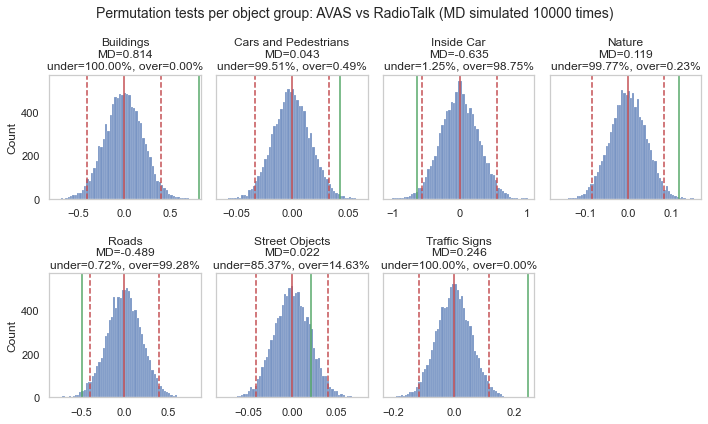

In [10]:
fin_grps = gaze_levs.columns.difference(["condition"]).tolist()

# collect conditions indices
avas_idx = gaze_levs[gaze_levs.condition == "AVAS"].index.tolist()
radio_idx = gaze_levs[gaze_levs.condition == "RadioTalk"].index.tolist()

# participants progress bar
grps_pbar = tqdm(
    iterable=fin_grps,
    total=len(fin_grps),
    desc="📂 groups",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

NROWS = 2
NCOLS = 4

N_PERMS = 10000

fig, axes = plt.subplots(NROWS, NCOLS, sharey=True, figsize=(10, 6))
fig.suptitle(
    f"Permutation tests per object group: AVAS vs RadioTalk (MD simulated {N_PERMS} times)",
    fontsize=14,
)

r = 0
c = 0
for i, g in enumerate(grps_pbar):
    # select group to test
    sel = gaze_levs[g]
    # select values of each condition
    avas = sel.loc[avas_idx].values.tolist()
    radio = sel.loc[radio_idx].values.tolist()
    # do the permutation tests
    actual, stats, under = permutationTest(avas, radio, N_PERMS)
    # prepare title, compute mean and std
    title = (
        f"{g}\nMD={actual:.3f}\nunder={under:.2f}%, over={100.0 - under:.2f}%"
    )
    std = np.std(stats)
    mean = np.mean(stats)
    # plot results
    ax = sns.histplot(data=stats, ax=axes[r, c], stat="count")
    ax.set_title(title)
    ax.grid(False)
    axes[r, c].axvline(actual, color="g")
    axes[r, c].axvline(mean, color="r")
    axes[r, c].axvline(mean - 2 * std, linestyle="--", color="r")
    axes[r, c].axvline(mean + 2 * std, linestyle="--", color="r")
    if i == 3:
        r = 1
        c = 0
    else:
        c += 1

fig.delaxes(axes[1, 3])
plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
plt.show()

📄 0 of 7 📂 groups processed:                                                                                  …

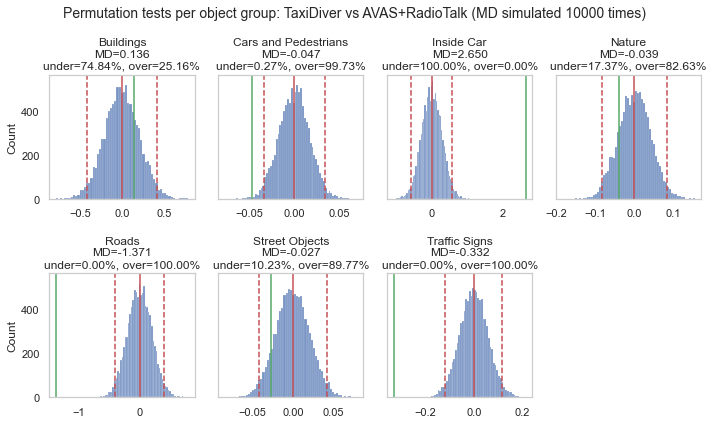

In [11]:
fin_grps = gaze_levs.columns.difference(["condition"]).tolist()

# collect conditions indices
avas_idx = gaze_levs[gaze_levs.condition == "AVAS"].index.tolist()
radio_idx = gaze_levs[gaze_levs.condition == "RadioTalk"].index.tolist()
taxi_idx = gaze_levs[gaze_levs.condition == "TaxiDriver"].index.tolist()

# participants progress bar
grps_pbar = tqdm(
    iterable=fin_grps,
    total=len(fin_grps),
    desc="📂 groups",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

NROWS = 2
NCOLS = 4

N_PERMS = 10000

fig, axes = plt.subplots(NROWS, NCOLS, sharey=True, figsize=(10, 6))
fig.suptitle(
    f"Permutation tests per object group: TaxiDiver vs AVAS+RadioTalk (MD simulated {N_PERMS} times)",
    fontsize=14,
)

r = 0
c = 0
for i, g in enumerate(grps_pbar):
    # select group to test
    sel = gaze_levs[g]
    # select values of each condition
    avas = sel.loc[avas_idx].values.tolist()
    radio = sel.loc[radio_idx].values.tolist()
    taxi = sel.loc[taxi_idx].values.tolist()
    # combine avas + radio (autonomous conditions)
    autonomous = avas + radio
    # do the permutation tests
    actual, stats, under = permutationTest(taxi, autonomous, N_PERMS)
    # prepare title, compute mean and std
    title = (
        f"{g}\nMD={actual:.3f}\nunder={under:.2f}%, over={100.0 - under:.2f}%"
    )
    std = np.std(stats)
    mean = np.mean(stats)
    # plot results
    ax = sns.histplot(data=stats, ax=axes[r, c], stat="count")
    ax.set_title(title)
    ax.grid(False)
    axes[r, c].axvline(actual, color="g")
    axes[r, c].axvline(mean, color="r")
    axes[r, c].axvline(mean - 2 * std, linestyle="--", color="r")
    axes[r, c].axvline(mean + 2 * std, linestyle="--", color="r")
    if i == 3:
        r = 1
        c = 0
    else:
        c += 1

fig.delaxes(axes[1, 3])
plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
plt.show()

📄 0 of 2 📂 groups processed:                                                                                  …

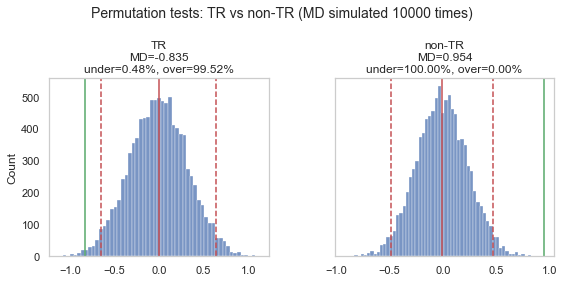

In [12]:
# TR and non-TR groups
tr_grps = gaze_ltr.columns.difference(["condition"]).tolist()

# collect conditions indices
avas_idx = gaze_ltr[gaze_ltr.condition == "AVAS"].index.tolist()
radio_idx = gaze_ltr[gaze_ltr.condition == "RadioTalk"].index.tolist()
taxi_idx = gaze_levs[gaze_levs.condition == "TaxiDriver"].index.tolist()

# participants progress bar
grps_pbar = tqdm(
    iterable=tr_grps,
    total=len(tr_grps),
    desc="📂 groups",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

N_PERMS = 10000

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))
fig.suptitle(
    f"Permutation tests: TR vs non-TR (MD simulated {N_PERMS} times)",
    fontsize=14,
)

for i, g in enumerate(grps_pbar):
    # select group to test
    sel = gaze_ltr[g]
    # select values of each condition
    avas = sel.loc[avas_idx].values.tolist()
    radio = sel.loc[radio_idx].values.tolist()
    # do the permutation tests
    actual, stats, under = permutationTest(avas, radio, N_PERMS)
    # prepare title, compute mean and std
    title = (
        f"{g}\nMD={actual:.3f}\nunder={under:.2f}%, over={100.0 - under:.2f}%"
    )
    std = np.std(stats)
    mean = np.mean(stats)
    # plot results
    ax = sns.histplot(data=stats, ax=axes[i], stat="count")
    ax.set_title(title)
    ax.grid(False)
    axes[i].axvline(actual, color="g")
    axes[i].axvline(mean, color="r")
    axes[i].axvline(mean - 2 * std, linestyle="--", color="r")
    axes[i].axvline(mean + 2 * std, linestyle="--", color="r")

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

📄 0 of 2 📂 groups processed:                                                                                  …

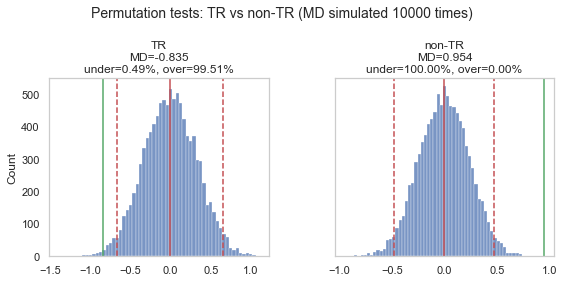

In [13]:
# TR and non-TR groups
tr_grps = gaze_ltr.columns.difference(["condition"]).tolist()

# collect conditions indices
avas_idx = gaze_ltr[gaze_ltr.condition == "AVAS"].index.tolist()
radio_idx = gaze_ltr[gaze_ltr.condition == "RadioTalk"].index.tolist()

# participants progress bar
grps_pbar = tqdm(
    iterable=tr_grps,
    total=len(tr_grps),
    desc="📂 groups",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

N_PERMS = 10000

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))
fig.suptitle(
    f"Permutation tests: TR vs non-TR (MD simulated {N_PERMS} times)",
    fontsize=14,
)

for i, g in enumerate(grps_pbar):
    # select group to test
    sel = gaze_ltr[g]
    # select values of each condition
    avas = sel.loc[avas_idx].values.tolist()
    radio = sel.loc[radio_idx].values.tolist()
    # do the permutation tests
    actual, stats, under = permutationTest(avas, radio, N_PERMS)
    # prepare title, compute mean and std
    title = (
        f"{g}\nMD={actual:.3f}\nunder={under:.2f}%, over={100.0 - under:.2f}%"
    )
    std = np.std(stats)
    mean = np.mean(stats)
    # plot results
    ax = sns.histplot(data=stats, ax=axes[i], stat="count")
    ax.set_title(title)
    ax.grid(False)
    axes[i].axvline(actual, color="g")
    axes[i].axvline(mean, color="r")
    axes[i].axvline(mean - 2 * std, linestyle="--", color="r")
    axes[i].axvline(mean + 2 * std, linestyle="--", color="r")

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

In [15]:
gaze_lman = copy.deepcopy(gaze_levs)

grp_conversion = {g: g.replace(" ", "") for g in fin_grps}
gaze_lman = gaze_lman.rename(columns=grp_conversion)
simple_grps = list(grp_conversion.values())
display(simple_grps)
display(gaze_lman)

['Buildings',
 'CarsandPedestrians',
 'InsideCar',
 'Nature',
 'Roads',
 'StreetObjects',
 'TrafficSigns']

,Buildings,InsideCar,Nature,condition,CarsandPedestrians,Roads,StreetObjects,TrafficSigns
4f583872ffed48249874b00f3d389cfc,18.414,1.881,3.597,TaxiDriver,2.046,18.282,1.155,13.332
33d68ad55ef544fab9fd08108e3913ca,0.000,28.677,0.297,AVAS,0.594,30.360,0.363,4.620
8598a83e2af441b8bcd0ae5d84beb875,38.313,0.627,0.924,RadioTalk,0.000,0.000,0.363,9.207
37d7e67934974217830bb429bba7fd76,17.259,4.719,5.049,AVAS,3.630,1.452,2.013,18.777
42bac596059749b5b8e8e83ae61de9b4,34.584,0.528,6.402,TaxiDriver,0.000,0.000,2.310,10.362
...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34.056,6.435,2.739,AVAS,0.000,0.000,1.023,8.382
611d35a7c3e940cc82495e53c2a8532d,19.041,24.288,4.686,TaxiDriver,0.000,2.838,1.056,9.537
3b6fda285d9e412eb081986b2f22a2e3,7.821,18.381,0.660,AVAS,0.462,16.599,6.996,5.577
18ffb0abdc8642098c479380bfa533d1,14.718,5.478,4.950,RadioTalk,0.264,6.402,1.485,12.045


In [16]:
formula = " + ".join(simple_grps)
formula += " ~ condition"
formula

'Buildings + CarsandPedestrians + InsideCar + Nature + Roads + StreetObjects + TrafficSigns ~ condition'

In [21]:
# fit manova
manova_result = MANOVA.from_formula(formula, gaze_lman)
df_manova = manova_result.mv_test().summary_frame
display(df_manova)

Value Num DF    Den DF   F Value Pr > F
Effect    Statistic                                                      
Intercept Wilks' lambda           0.066      7 24347.000 49334.565  0.000
          Pillai's trace          0.934  7.000 24347.000 49334.565  0.000
          Hotelling-Lawley trace 14.184      7 24347.000 49334.565  0.000
          Roy's greatest root    14.184      7     24347 49334.565  0.000
condition Wilks' lambda           0.988     14 48694.000    20.779  0.000
          Pillai's trace          0.012 14.000 48696.000    20.740  0.000
          Hotelling-Lawley trace  0.012     14 38951.840    20.817  0.000
          Roy's greatest root     0.011      7     24348    37.419  0.000

P values

In [22]:
display(df_manova.loc[("condition", "Wilks' lambda")]["Pr > F"])
display(df_manova.loc[("condition", "Pillai's trace")]["Pr > F"])
display(df_manova.loc[("condition", "Hotelling-Lawley trace")]["Pr > F"])
display(df_manova.loc[("condition", "Roy's greatest root")]["Pr > F"])

1.385858227639466e-53

1.7920934762542884e-53

1.181993790292589e-53

1.5612172204941519e-52

__MANOVA's post-hoc test__

Prior probabilities of groups:


array([0.33876663, 0.32468386, 0.33654952])

Group means:


array([[15.51117986,  0.75192886, 19.33932784,  2.67851133, 11.23844976,
         1.21268901,  7.62859932],
       [14.69710584,  0.70903263, 19.97415554,  2.55974924, 11.72756487,
         1.1911047 ,  7.38283612],
       [15.24922472,  0.68353922, 22.29997645,  2.5812224 , 10.10709442,
         1.17542723,  7.17598829]])

Coefficients of linear discriminants:


array([[ 0.08990864,  0.06882243],
       [ 0.25846108,  0.37648978],
       [ 0.07818017,  0.0265783 ],
       [ 0.01789473,  0.00692712],
       [ 0.00648752,  0.0132627 ],
       [ 0.07487105, -0.19474025],
       [-0.07023442,  0.16224731]])

Variance explained by each of the selected components:


array([0.89868923, 0.10131077])

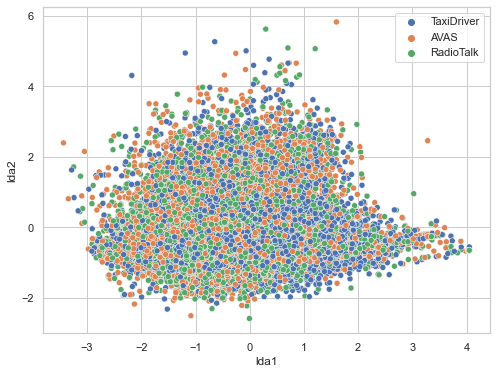

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

# target, outcome, label, dependent variable
target = "condition"
# predictor, attribute, independent variable, input, regressor, covariate
features = gaze_lman.columns.difference([target])
# each row (features and target) is an observation

X = gaze_lman[features]
y = gaze_lman[target]
post_hoc = lda().fit(X=X, y=y)

# get Prior probabilities of groups:
print("Prior probabilities of groups:")
display(post_hoc.priors_)

# get group means
print("Group means:")
display(post_hoc.means_)

# get Coefficients of linear discriminants
print("Coefficients of linear discriminants:")
display(post_hoc.scalings_)

# get Proportion of trace (variance explained by each of the selected components)
print("Variance explained by each of the selected components:")
display(post_hoc.explained_variance_ratio_)

# plot
X_new = pd.DataFrame(
    lda().fit(X=X, y=y).transform(X), columns=["lda1", "lda2"]
)
X_new["condition"] = gaze_lman["condition"]
sns.scatterplot(
    data=X_new, x="lda1", y="lda2", hue=gaze_lman.condition.tolist()
)
plt.show()

In [161]:
gaze_lman_mod = copy.deepcopy(gaze_lman)

In [162]:
gaze_lman_mod.iloc[0]

Buildings                 18.414
InsideCar                  1.881
Nature                     3.597
condition             TaxiDriver
CarsandPedestrians         2.046
Roads                     18.282
StreetObjects              1.155
TrafficSigns              13.332
Name: 4f583872ffed48249874b00f3d389cfc, dtype: object

In [163]:
coeffs = post_hoc.coef_.tolist()
coeffs

[[-0.002841193074483318,
  -0.0003968446041887045,
  -0.003917588777747943,
  -0.0008600062123129716,
  0.00015587956874050455,
  -0.013329796515780631,
  0.011615506054542115],
 [-0.010326829307884105,
  -0.037156223295190124,
  -0.007588760161528176,
  -0.0017722708573661614,
  -0.0010920563303419882,
  0.001939285226981765,
  -0.0009648331093392358],
 [0.012822648557314768,
  0.036245672642128114,
  0.011264601727773925,
  0.002575457996565314,
  0.0008966474489040546,
  0.01154669799642963,
  -0.010761210226591664]]

In [164]:
conds = post_hoc.classes_.tolist()
conds

['AVAS', 'RadioTalk', 'TaxiDriver']

In [165]:
feats = post_hoc.feature_names_in_.tolist()
feats

['Buildings',
 'CarsandPedestrians',
 'InsideCar',
 'Nature',
 'Roads',
 'StreetObjects',
 'TrafficSigns']

In [166]:
super_ind = []
ind_vars = gaze_lman.columns.difference(["condition"])
for part in gaze_lman.index.tolist():
    cur = gaze_lman.loc[part]
    cond = cur.condition
    c = conds.index(cond)
    svar = sum([cur[dvar] * coeffs[c][i] for i, dvar in enumerate(feats)])
    super_ind.append(svar)

In [167]:
gaze_lman_mod["SuperVar"] = super_ind
gaze_lman_mod

,Buildings,InsideCar,Nature,condition,CarsandPedestrians,Roads,StreetObjects,TrafficSigns,SuperVar
4f583872ffed48249874b00f3d389cfc,18.414,1.881,3.597,TaxiDriver,2.046,18.282,1.155,13.332,0.227
33d68ad55ef544fab9fd08108e3913ca,0.000,28.677,0.297,AVAS,0.594,30.360,0.363,4.620,-0.059
8598a83e2af441b8bcd0ae5d84beb875,38.313,0.627,0.924,RadioTalk,0.000,0.000,0.363,9.207,-0.410
37d7e67934974217830bb429bba7fd76,17.259,4.719,5.049,AVAS,3.630,1.452,2.013,18.777,0.118
42bac596059749b5b8e8e83ae61de9b4,34.584,0.528,6.402,TaxiDriver,0.000,0.000,2.310,10.362,0.381
...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34.056,6.435,2.739,AVAS,0.000,0.000,1.023,8.382,-0.041
611d35a7c3e940cc82495e53c2a8532d,19.041,24.288,4.686,TaxiDriver,0.000,2.838,1.056,9.537,0.442
3b6fda285d9e412eb081986b2f22a2e3,7.821,18.381,0.660,AVAS,0.462,16.599,6.996,5.577,-0.121
18ffb0abdc8642098c479380bfa533d1,14.718,5.478,4.950,RadioTalk,0.264,6.402,1.485,12.045,-0.228


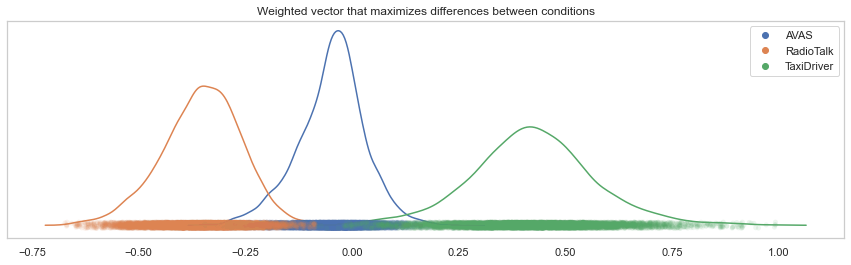

In [248]:
from matplotlib.lines import Line2D

STYLE = "whitegrid"
sns.set(rc={"figure.figsize": (15, 4)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style
palette = itertools.cycle(sns.color_palette(palette="deep"))
for c in conds:
    color = next(palette)
    cur = gaze_lman_mod[gaze_lman_mod.condition == c]
    ax = sns.stripplot(data=cur, x="SuperVar", color=color, alpha=0.1)
    ax.grid(False)
    ax.set_xlabel(None)

    ax = sns.kdeplot(data=cur, x="SuperVar", color=color)
    ax.grid(False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

avas_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[0],
    label="AVAS",
    linestyle="None",
)
radio_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[1],
    label="RadioTalk",
    linestyle="None",
)
taxi_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[2],
    label="TaxiDriver",
    linestyle="None",
)

plt.title("Weighted vector that maximizes differences between conditions")
plt.legend(handles=[avas_patch, radio_patch, taxi_patch])
plt.gca().invert_yaxis()
plt.show()

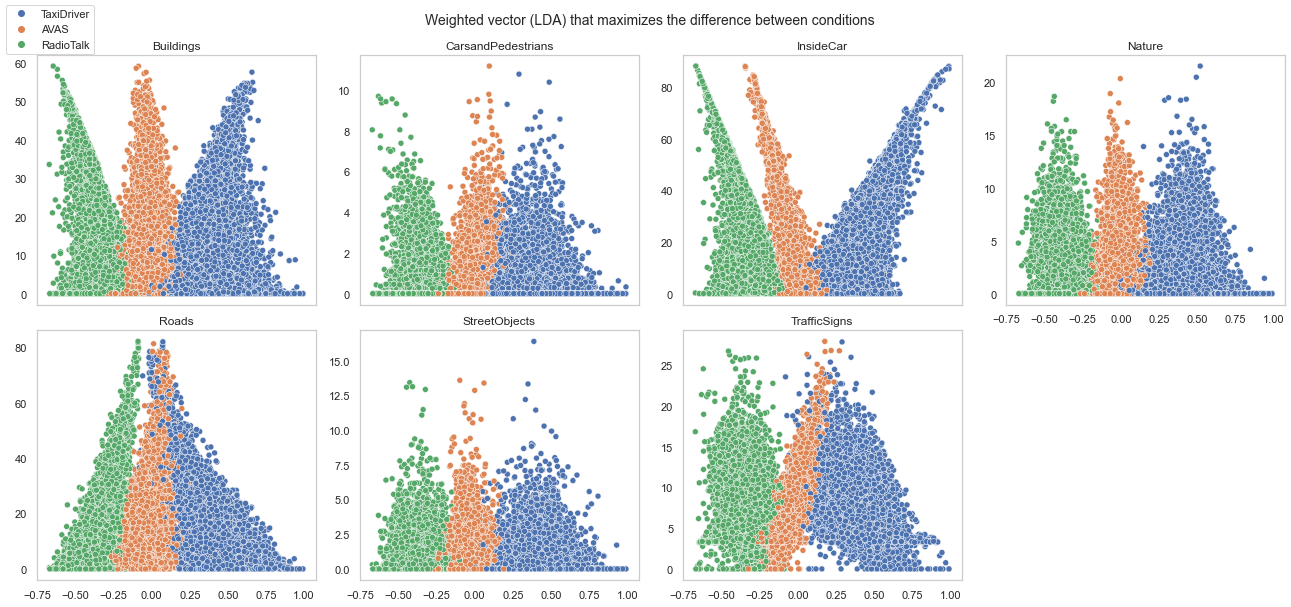

In [168]:
from matplotlib.lines import Line2D

NROWS = 2
NCOLS = 4

fig, axes = plt.subplots(NROWS, NCOLS, sharex=True, figsize=(18, 8.5))
fig.suptitle(
    "Weighted vector (LDA) that maximizes the difference between conditions",
    fontsize=14,
)

groups = gaze_lman.columns.difference(["condition"])

r = 0
c = 0
for i, g in enumerate(groups):
    # prepare title, compute mean and std
    title = g
    # plot results
    ax = sns.scatterplot(
        data=gaze_lman_mod,
        x="SuperVar",
        y=g,
        hue="condition",
        ax=axes[r, c],
        legend=False,
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(title)
    ax.grid(False)
    if i == 3:
        r = 1
        c = 0
        ax.xaxis.set_tick_params(
            which="both", labelbottom=True, labeltop=False
        )
    else:
        c += 1

fig.delaxes(axes[1, 3])
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
palette = itertools.cycle(sns.color_palette(palette="deep"))  # color palette
colors = [next(palette) for i in range(3)]
taxi_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[0],
    label="TaxiDriver",
    linestyle="None",
)
avas_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[1],
    label="AVAS",
    linestyle="None",
)
radio_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[2],
    label="RadioTalk",
    linestyle="None",
)
fig.legend(handles=[taxi_patch, avas_patch, radio_patch], loc="upper left")
plt.show()

In [169]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols("SuperVar ~ condition", data=gaze_lman_mod).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
condition,2465.386,2.000,102523.752,0.000
Residual,292.808,24353.000,NaN,NaN


In [170]:
anova_table.loc["condition"]["PR(>F)"]

0.0

In [171]:
gaze_lman_all = copy.deepcopy(gaze_lman)
ind_vars = gaze_lman.columns.difference(["condition"])
super_ind = {f"{g}Super": [] for g in ind_vars}

for part in gaze_lman.index.tolist():
    cur = gaze_lman.loc[part]
    cond = cur.condition
    c = conds.index(cond)
    for i, dvar in enumerate(feats):
        svar = cur[dvar] * coeffs[c][i]
        super_ind[f"{dvar}Super"].append(svar)

In [172]:
for k in super_ind.keys():
    gaze_lman_all[k] = super_ind[k]
gaze_lman_all

,Buildings,InsideCar,Nature,condition,CarsandPedestrians,Roads,StreetObjects,TrafficSigns,BuildingsSuper,CarsandPedestriansSuper,InsideCarSuper,NatureSuper,RoadsSuper,StreetObjectsSuper,TrafficSignsSuper
4f583872ffed48249874b00f3d389cfc,18.414,1.881,3.597,TaxiDriver,2.046,18.282,1.155,13.332,0.236,0.074,0.021,0.009,0.016,0.013,-0.143
33d68ad55ef544fab9fd08108e3913ca,0.000,28.677,0.297,AVAS,0.594,30.360,0.363,4.620,-0.000,-0.000,-0.112,-0.000,0.005,-0.005,0.054
8598a83e2af441b8bcd0ae5d84beb875,38.313,0.627,0.924,RadioTalk,0.000,0.000,0.363,9.207,-0.396,-0.000,-0.005,-0.002,-0.000,0.001,-0.009
37d7e67934974217830bb429bba7fd76,17.259,4.719,5.049,AVAS,3.630,1.452,2.013,18.777,-0.049,-0.001,-0.018,-0.004,0.000,-0.027,0.218
42bac596059749b5b8e8e83ae61de9b4,34.584,0.528,6.402,TaxiDriver,0.000,0.000,2.310,10.362,0.443,0.000,0.006,0.016,0.000,0.027,-0.112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,34.056,6.435,2.739,AVAS,0.000,0.000,1.023,8.382,-0.097,-0.000,-0.025,-0.002,0.000,-0.014,0.097
611d35a7c3e940cc82495e53c2a8532d,19.041,24.288,4.686,TaxiDriver,0.000,2.838,1.056,9.537,0.244,0.000,0.274,0.012,0.003,0.012,-0.103
3b6fda285d9e412eb081986b2f22a2e3,7.821,18.381,0.660,AVAS,0.462,16.599,6.996,5.577,-0.022,-0.000,-0.072,-0.001,0.003,-0.093,0.065
18ffb0abdc8642098c479380bfa533d1,14.718,5.478,4.950,RadioTalk,0.264,6.402,1.485,12.045,-0.152,-0.010,-0.042,-0.009,-0.007,0.003,-0.012


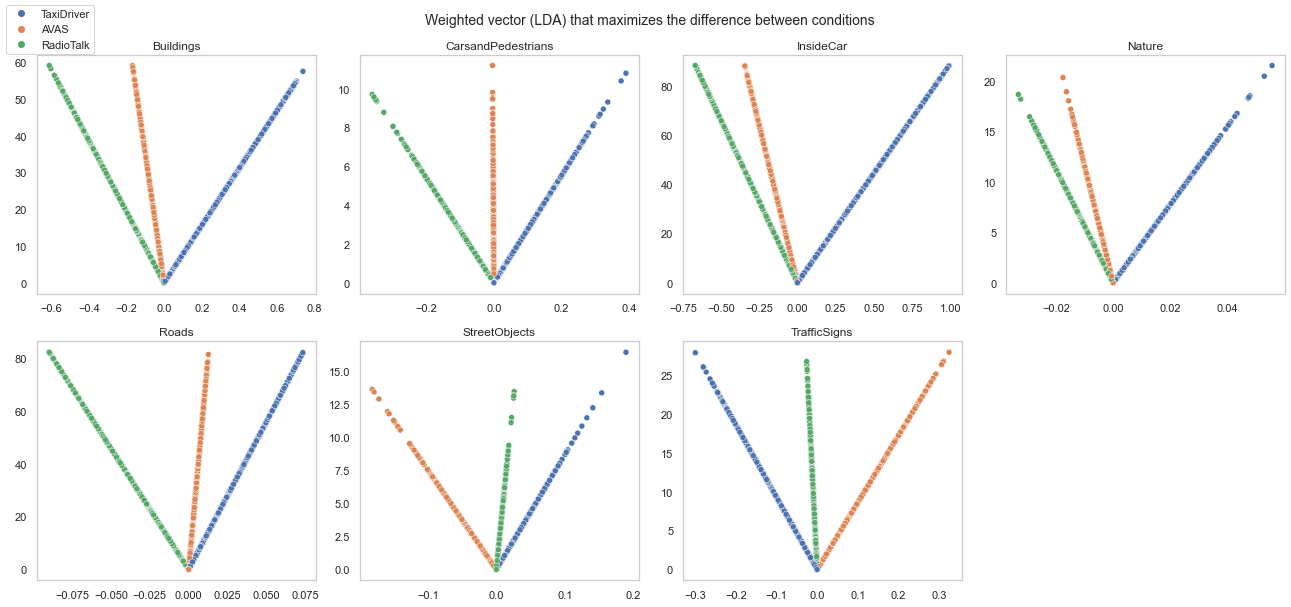

In [173]:
from matplotlib.lines import Line2D

NROWS = 2
NCOLS = 4

fig, axes = plt.subplots(NROWS, NCOLS, sharex=False, figsize=(18, 8.5))
fig.suptitle(
    "Weighted vector (LDA) that maximizes the difference between conditions",
    fontsize=14,
)

groups = gaze_lman.columns.difference(["condition"])

r = 0
c = 0
for i, g in enumerate(groups):
    # prepare title, compute mean and std
    title = g
    # plot results
    ax = sns.scatterplot(
        data=gaze_lman_all,
        x=f"{g}Super",
        y=g,
        hue="condition",
        ax=axes[r, c],
        legend=False,
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(title)
    ax.grid(False)
    if i == 3:
        r = 1
        c = 0
        # ax.xaxis.set_tick_params(
        #     which="both", labelbottom=True, labeltop=False
        # )
    else:
        c += 1

fig.delaxes(axes[1, 3])
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
palette = itertools.cycle(sns.color_palette(palette="deep"))  # color palette
colors = [next(palette) for i in range(3)]
taxi_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[0],
    label="TaxiDriver",
    linestyle="None",
)
avas_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[1],
    label="AVAS",
    linestyle="None",
)
radio_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[2],
    label="RadioTalk",
    linestyle="None",
)
fig.legend(handles=[taxi_patch, avas_patch, radio_patch], loc="upper left")
plt.show()

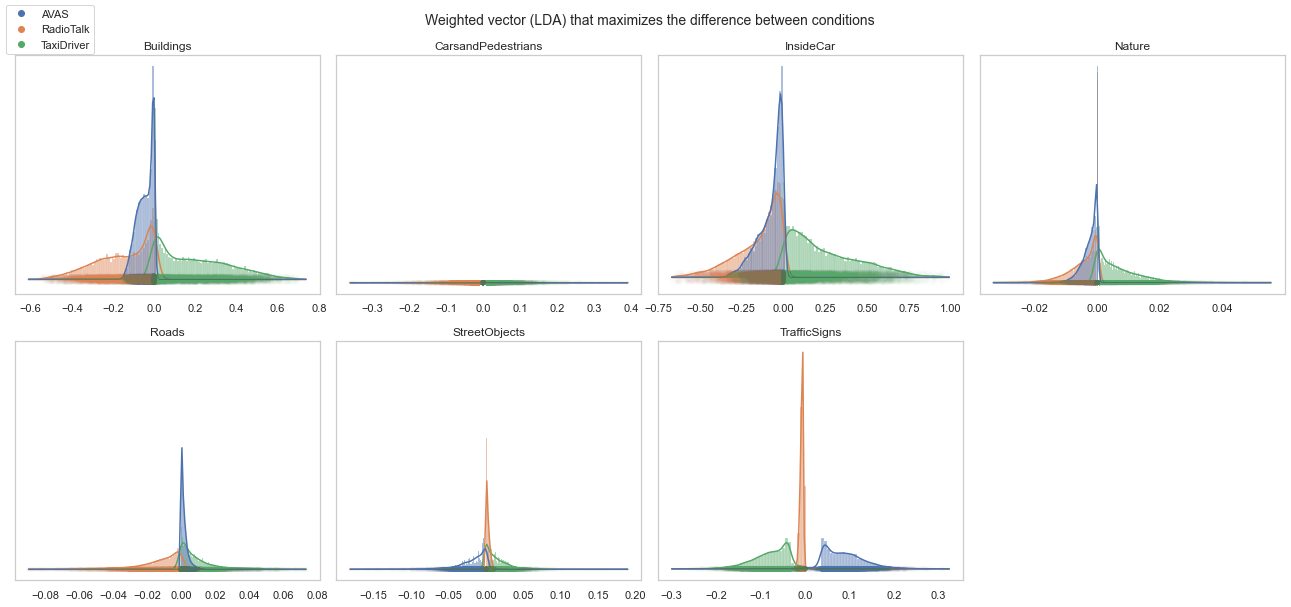

In [270]:
from matplotlib.lines import Line2D

NROWS = 2
NCOLS = 4

fig, axes = plt.subplots(NROWS, NCOLS, sharex=False, figsize=(18, 8.5))
fig.suptitle(
    "Weighted vector (LDA) that maximizes the difference between conditions",
    fontsize=14,
)

groups = gaze_lman.columns.difference(["condition"])

r = 0
c = 0
for i, g in enumerate(groups):
    # prepare title, compute mean and std
    title = g
    palette = itertools.cycle(sns.color_palette(palette="deep"))
    for cond in conds:
        color = next(palette)
        cur = gaze_lman_all[gaze_lman_mod.condition == cond]
        ax = sns.stripplot(
            data=cur, x=f"{g}Super", color=color, alpha=0.01, ax=axes[r, c]
        )
        ax.grid(False)
        ax.set_xlabel(None)

        # ax = sns.histplot(
        #     data=cur, x=f"{g}Super", color=color, ax=axes[r, c], legend=False, stat="percent", kde=True
        # )
        # ax.grid(False)
        # ax.set_xlabel(None)
        # ax.set_ylabel(None)
        # ax.set_title(title)
    palette = itertools.cycle(sns.color_palette(palette="deep"))
    ax = sns.histplot(
        data=gaze_lman_all, x=f"{g}Super", hue="condition", hue_order=conds, ax=axes[r, c], palette=palette, legend=False, stat="density", kde=True
    )
    ax.grid(False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(title)

    ax.invert_yaxis()
    # # plot results
    # ax = sns.scatterplot(
    #     data=gaze_lman_all,
    #     x=f"{g}Super",
    #     y=g,
    #     hue="condition",
    #     ax=axes[r, c],
    #     legend=False,
    # )
    # ax.set_xlabel(None)
    # ax.set_ylabel(None)
    # ax.set_title(title)
    # ax.grid(False)
    if i == 3:
        r = 1
        c = 0
        # ax.xaxis.set_tick_params(
        #     which="both", labelbottom=True, labeltop=False
        # )
    else:
        c += 1

fig.delaxes(axes[1, 3])
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
palette = itertools.cycle(sns.color_palette(palette="deep"))  # color palette
colors = [next(palette) for i in range(3)]
avas_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[0],
    label="AVAS",
    linestyle="None",
)
radio_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[1],
    label="RadioTalk",
    linestyle="None",
)
taxi_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[2],
    label="TaxiDriver",
    linestyle="None",
)

fig.legend(handles=[avas_patch, radio_patch, taxi_patch], loc="upper left")
plt.show()

In [ ]:
from matplotlib.lines import Line2D

STYLE = "whitegrid"
sns.set(rc={"figure.figsize": (15, 4)})  # figure (plot) size
sns.set_style(STYLE)  # set seaborn plotting style
palette = itertools.cycle(sns.color_palette(palette="deep"))
for c in conds:
    color = next(palette)
    cur = gaze_lman_mod[gaze_lman_mod.condition == c]
    ax = sns.stripplot(data=cur, x="SuperVar", color=color, alpha=0.1)
    ax.grid(False)
    ax.set_xlabel(None)

    ax = sns.kdeplot(data=cur, x="SuperVar", color=color, common_norm=True)
    ax.grid(False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

avas_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[0],
    label="AVAS",
    linestyle="None",
)
radio_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[1],
    label="RadioTalk",
    linestyle="None",
)
taxi_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[2],
    label="TaxiDriver",
    linestyle="None",
)

plt.title("Weighted vector that maximizes differences between conditions")
plt.legend(handles=[avas_patch, radio_patch, taxi_patch])
plt.gca().invert_yaxis()
plt.show()

In [174]:
gaze_lman_tr = copy.deepcopy(gaze_lman_all)
gaze_lman_tr = gaze_lman_tr.filter(regex="Super$", axis=1)
gaze_lman_tr

,BuildingsSuper,CarsandPedestriansSuper,InsideCarSuper,NatureSuper,RoadsSuper,StreetObjectsSuper,TrafficSignsSuper
4f583872ffed48249874b00f3d389cfc,0.236,0.074,0.021,0.009,0.016,0.013,-0.143
33d68ad55ef544fab9fd08108e3913ca,-0.000,-0.000,-0.112,-0.000,0.005,-0.005,0.054
8598a83e2af441b8bcd0ae5d84beb875,-0.396,-0.000,-0.005,-0.002,-0.000,0.001,-0.009
37d7e67934974217830bb429bba7fd76,-0.049,-0.001,-0.018,-0.004,0.000,-0.027,0.218
42bac596059749b5b8e8e83ae61de9b4,0.443,0.000,0.006,0.016,0.000,0.027,-0.112
...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,-0.097,-0.000,-0.025,-0.002,0.000,-0.014,0.097
611d35a7c3e940cc82495e53c2a8532d,0.244,0.000,0.274,0.012,0.003,0.012,-0.103
3b6fda285d9e412eb081986b2f22a2e3,-0.022,-0.000,-0.072,-0.001,0.003,-0.093,0.065
18ffb0abdc8642098c479380bfa533d1,-0.152,-0.010,-0.042,-0.009,-0.007,0.003,-0.012


In [175]:
# TR vs non-TR
# gaze_ltr = pd.DataFrame(columns=["TR", "non-TR"])
gaze_lman_tr["TRSuper"] = (
    gaze_lman_tr["CarsandPedestriansSuper"]
    + gaze_lman_tr["RoadsSuper"]
    + gaze_lman_tr["TrafficSignsSuper"]
    + gaze_lman_tr["InsideCarSuper"]
)
gaze_lman_tr["non-TRSuper"] = (
    gaze_lman_tr["BuildingsSuper"]
    + gaze_lman_tr["NatureSuper"]
    + gaze_lman_tr["StreetObjectsSuper"]
)
gaze_lman_tr = gaze_lman_tr.filter(regex="TRSuper$", axis=1)
gaze_lman_tr

,TRSuper,non-TRSuper
4f583872ffed48249874b00f3d389cfc,-0.032,0.259
33d68ad55ef544fab9fd08108e3913ca,-0.054,-0.005
8598a83e2af441b8bcd0ae5d84beb875,-0.014,-0.397
37d7e67934974217830bb429bba7fd76,0.198,-0.080
42bac596059749b5b8e8e83ae61de9b4,-0.106,0.487
...,...,...
cfe9482181f74f80b88cd4b1c048ab94,0.072,-0.113
611d35a7c3e940cc82495e53c2a8532d,0.174,0.268
3b6fda285d9e412eb081986b2f22a2e3,-0.005,-0.116
18ffb0abdc8642098c479380bfa533d1,-0.070,-0.158


In [176]:
gaze_lman_tr["TR"] = gaze_ltr["TR"]
gaze_lman_tr["non-TR"] = gaze_ltr["non-TR"]
gaze_lman_tr["condition"] = gaze_ltr["condition"]
gaze_lman_tr

,TRSuper,non-TRSuper,TR,non-TR,condition
4f583872ffed48249874b00f3d389cfc,-0.032,0.259,35.541,23.166,TaxiDriver
33d68ad55ef544fab9fd08108e3913ca,-0.054,-0.005,64.251,0.660,AVAS
8598a83e2af441b8bcd0ae5d84beb875,-0.014,-0.397,9.834,39.600,RadioTalk
37d7e67934974217830bb429bba7fd76,0.198,-0.080,28.578,24.321,AVAS
42bac596059749b5b8e8e83ae61de9b4,-0.106,0.487,10.890,43.296,TaxiDriver
...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,0.072,-0.113,14.817,37.818,AVAS
611d35a7c3e940cc82495e53c2a8532d,0.174,0.268,36.663,24.783,TaxiDriver
3b6fda285d9e412eb081986b2f22a2e3,-0.005,-0.116,41.019,15.477,AVAS
18ffb0abdc8642098c479380bfa533d1,-0.070,-0.158,24.189,21.153,RadioTalk


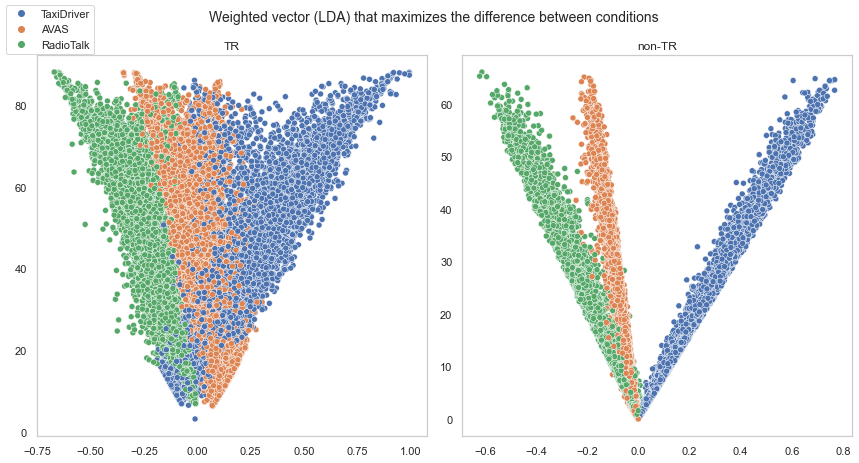

In [177]:
from matplotlib.lines import Line2D

NCOLS = 2

fig, axes = plt.subplots(ncols=NCOLS, sharex=False, figsize=(12, 6.5))
fig.suptitle(
    "Weighted vector (LDA) that maximizes the difference between conditions",
    fontsize=14,
)

groups = ["TR", "non-TR"]

for i, g in enumerate(groups):
    # prepare title, compute mean and std
    title = g
    # plot results
    ax = sns.scatterplot(
        data=gaze_lman_tr,
        x=f"{g}Super",
        y=g,
        hue="condition",
        ax=axes[i],
        legend=False,
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(title)
    ax.grid(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
palette = itertools.cycle(sns.color_palette(palette="deep"))  # color palette
colors = [next(palette) for i in range(3)]
taxi_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[0],
    label="TaxiDriver",
    linestyle="None",
)
avas_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[1],
    label="AVAS",
    linestyle="None",
)
radio_patch = Line2D(
    [],
    [],
    marker="o",
    color=colors[2],
    label="RadioTalk",
    linestyle="None",
)
fig.legend(handles=[taxi_patch, avas_patch, radio_patch], loc="upper left")
plt.show()

In [181]:
gaze_tr = gaze_ltr.rename(columns={"non-TR": "nonTR"})
gaze_tr

,TR,nonTR,condition
4f583872ffed48249874b00f3d389cfc,35.541,23.166,TaxiDriver
33d68ad55ef544fab9fd08108e3913ca,64.251,0.660,AVAS
8598a83e2af441b8bcd0ae5d84beb875,9.834,39.600,RadioTalk
37d7e67934974217830bb429bba7fd76,28.578,24.321,AVAS
42bac596059749b5b8e8e83ae61de9b4,10.890,43.296,TaxiDriver
...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,14.817,37.818,AVAS
611d35a7c3e940cc82495e53c2a8532d,36.663,24.783,TaxiDriver
3b6fda285d9e412eb081986b2f22a2e3,41.019,15.477,AVAS
18ffb0abdc8642098c479380bfa533d1,24.189,21.153,RadioTalk


In [183]:
formula = " + ".join(gaze_tr.columns.difference(["condition"]))
formula += " ~ condition"
formula

'TR + nonTR ~ condition'

In [185]:
# fit manova
manova_ltr = MANOVA.from_formula(formula, gaze_tr)
df_manova_ltr = manova_ltr.mv_test().summary_frame
display(df_manova_ltr)

Value Num DF    Den DF    F Value Pr > F
Effect    Statistic                                                       
Intercept Wilks' lambda           0.068      2 24352.000 166108.446  0.000
          Pillai's trace          0.932  2.000 24352.000 166108.446  0.000
          Hotelling-Lawley trace 13.642      2 24352.000 166108.446  0.000
          Roy's greatest root    13.642      2     24352 166108.446  0.000
condition Wilks' lambda           0.997      4 48704.000     17.917  0.000
          Pillai's trace          0.003  4.000 48706.000     17.912  0.000
          Hotelling-Lawley trace  0.003      4 29221.360     17.922  0.000
          Roy's greatest root     0.002      2     24353     29.365  0.000

In [186]:
display(df_manova_ltr.loc[("condition", "Wilks' lambda")]["Pr > F"])
display(df_manova_ltr.loc[("condition", "Pillai's trace")]["Pr > F"])
display(df_manova_ltr.loc[("condition", "Hotelling-Lawley trace")]["Pr > F"])
display(df_manova_ltr.loc[("condition", "Roy's greatest root")]["Pr > F"])

1.0344107694413961e-14

1.0437618184682483e-14

1.0412982376551402e-14

1.828791411397835e-13

📄 0 of 10000 📂 permutations processed:                                                                        …

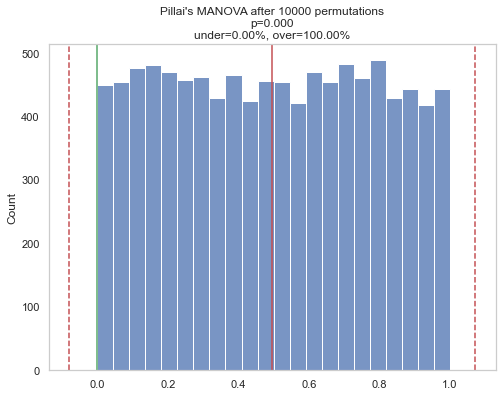

In [80]:
pd.options.display.float_format = "{:.10f}".format
manova_result = MANOVA.from_formula(formula, gaze_lman)
actual = manova_result.mv_test().summary_frame.loc[
    ("condition", "Pillai's trace")
]["Pr > F"]

gaze_lman_cp = copy.deepcopy(gaze_lman)
n_perms = 10000

stats = []
under = 0

# participants progress bar
perms_pbar = tqdm(
    iterable=range(n_perms),
    total=n_perms,
    desc="📂 permutations",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for count in perms_pbar:
    # shuffle values
    gaze_lman_cp.condition = np.random.permutation(
        gaze_lman.condition.values.tolist()
    )
    # compute statistic
    stat = MANOVA.from_formula(formula, gaze_lman_cp)
    stat = stat.mv_test().summary_frame.loc[("condition", "Pillai's trace")][
        "Pr > F"
    ]
    stats.append(stat)
    if stat <= actual:
        under += 1
under_per = under * 100.0 / (count + 1)


# prepare title, compute mean and std
title = f"Pillai's MANOVA after {n_perms} permutations\np={actual:.3f}\nunder={under:.2f}%, over={100.0 - under:.2f}%"
std = np.std(stats)
mean = np.mean(stats)

# plot results
ax = sns.histplot(data=stats, stat="count")
ax.set_title(title)
ax.grid(False)
ax.axvline(actual, color="g")
ax.axvline(mean, color="r")
ax.axvline(mean - 2 * std, linestyle="--", color="r")
ax.axvline(mean + 2 * std, linestyle="--", color="r")
plt.show()

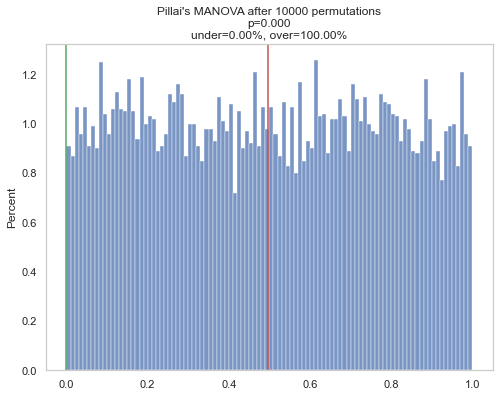

In [88]:
# plot results
ax = sns.histplot(data=stats, stat="percent", bins=100)
ax.set_title(title)
ax.grid(False)
ax.axvline(actual, color="g")
ax.axvline(mean, color="r")
# ax.axvline(mean - 2 * std, linestyle="--", color="r")
# ax.axvline(mean + 2 * std, linestyle="--", color="r")
plt.show()

In [92]:
smaller = 0
for p in stats:
    if p < 0.05:
        smaller += 1

smaller

488

In [90]:
smaller * 100 / len(stats)

4.88

In [93]:
std

0.28798445475900813

In [95]:
mean - 2 * std

-0.0791560981202466